# 利用K-means做客戶分群

## K-means基本概念

1. 先任意選擇K值(群聚中心)的位置與數量
2. 計算每個資料與各個K值的距離(通常是歐基李德距離Euclidean distance)，將資料歸類在距離最近的K值。
   如同k值間能夠劃出一條分類線，將各資料分區。
3. 將K值改為各資料區的中心點，因此K值會逐漸向密集的資料中心移動
4. 重複找出新的資料分區、分類線，循環多次直到K值或分類線不再變動

## 設定k值數量的方法 - [介紹網頁](https://blog.v123582.tw/2019/01/20/K-means-%E6%80%8E%E9%BA%BC%E9%81%B8-K/)

### 手肘法（elbow method）
其概念是基於 SSE（sum of the squared errors，誤差平方和）作為指標，
去計算每一個群中的每一個點，到群中心的距離。算法如下：
![SSE.png](https://raw.githubusercontent.com/Walilei/2020-Recommender-system/master/pic/SSE.png)
其中總共有 K 個群， Ci 代表其中一個群，mi 表示該群的中心點。

根據 K 與 SSE 作圖，可以從中觀察到使 SSE 的下降幅度由「快速轉為平緩」的點，一般稱這個點為拐點（Inflection point），我們會將他挑選為 K。因為該點可以確保 K 值由小逐漸遞增時的一個集群效益，因此適合作為分群的標準。

### 輪廓係數法（Silhouette Coefficient）
輪廓係數法的概念是「找出相同群凝聚度越小、不同群分離度越高」的值，也就是滿足 Cluster 一開始的目標。其算法如下：
![SC.png](https://raw.githubusercontent.com/Walilei/2020-Recommender-system/master/pic/SC.png)
其中，凝聚度（a）是指與相同群內的其他點的平均距離；分離度（b）是指與不同群的其他點的平均距離。S 是指以一個點作為計算的值，輪廓係數法則是將所有的點都計算 S 後再總和。S 值越大，表示效果越好，適合作為 K。

## 注意事項
- K-means和KNN不同。K-means是非監督式學習的分群方法之一；KNN則是監督式學習中用來預測物件所屬的分類
- K-means容易受到非常態分配以及極端值的影響，因此要確認用來判斷的特徵已經做過標準化

## Step 1. 特徵工程
首先必須決定需要用來做K-means的幾項特徵。[參考文章](https://www.itread01.com/content/1542164169.html)
>例如在我們參考的範例中，出發點是RFM模型，因此選用了每個客戶的訂單數量、距離上次訂單的平均時間、每筆訂單的產品數量作為特徵。
>由於專題主題是要預測客戶對產品的偏好，我們可以選擇產品種類(名稱)、各產品的購買次數、重複訂單數量、訂單總數等作為特徵。

選擇訂單總數、距離上次訂單的標準差、重複訂單的比例作為特徵：

In [1]:
import pandas as pd

In [2]:
# 讀取CSV檔

orders = pd.read_csv("./instacart_2017_05_01/orders.csv")
train = pd.read_csv("./instacart_2017_05_01/order_products__train.csv")
prior = pd.read_csv("./instacart_2017_05_01/order_products__prior.csv")

In [ ]:
# 檢視檔案內容 

print(orders)
print(train)
print(prior)

In [3]:
# 挑出訂單總數

order_num = orders.groupby("user_id").size()
order_num

user_id
1         11
2         15
3         13
4          6
5          5
          ..
206205     4
206206    68
206207    17
206208    50
206209    14
Length: 206209, dtype: int64

In [4]:
# 挑出客戶的購買頻率(訂單間隔天數的標準差)

# 觀察1號使用者的全部訂單
# users = orders.groupby("user_id")
# users.get_group(1)

# 先把含有0的列去掉，求標準差
order = orders[orders["days_since_prior_order"] != 0]
users = order.groupby("user_id")["days_since_prior_order"]
freq = users.std()
freq

user_id
1          6.450667
2         10.268912
3          5.134553
4          6.344289
5          5.446712
            ...    
206205    11.547005
206206     3.251693
206207    11.145814
206208     3.994622
206209    11.177473
Name: days_since_prior_order, Length: 206209, dtype: float64

In [5]:
# 挑出再次選購的商品比例
# 把prior, train訂單都整理出reorder數量
new_train = pd.DataFrame(columns=["order_id", "reorder", "total"])
new_train["order_id"] = train["order_id"].drop_duplicates()
new_train["reorder"] = list(train.groupby("order_id")["reordered"].sum())
new_train["total"] = list(train.groupby("order_id")["reordered"].count())

new_prior = pd.DataFrame(columns=["order_id", "reorder", "total"])
new_prior["order_id"] = prior["order_id"].drop_duplicates()
new_prior["reorder"] = list(prior.groupby("order_id")["reordered"].sum())
new_prior["total"] = list(prior.groupby("order_id")["reordered"].count())

print(new_train) 
print(new_prior)

         order_id  reorder  total
0               1        4      8
8              36        6      8
16             38        1      9
25             96        5      7
32             98       45     49
...           ...      ...    ...
1384591   3421049        1      6
1384597   3421056        3      5
1384602   3421058        7      8
1384610   3421063        4      4
1384614   3421070        3      3

[131209 rows x 3 columns]
          order_id  reorder  total
0                2        6      9
9                3        8      8
17               4       12     13
30               5       21     26
56               6        0      3
...            ...      ...    ...
32434455   3421079        0      1
32434456   3421080        4      9
32434465   3421081        0      7
32434472   3421082        4      7
32434479   3421083        4     10

[3214874 rows x 3 columns]


In [6]:
# 第一筆訂單一定沒有reorder，先去除
order = orders[orders["days_since_prior_order"].notnull()][["order_id", "user_id", "eval_set"]]

# order.merge(new_train, on="order_id", how="outer")
order_prior = order[order.eval_set == "prior"].merge(new_prior, on="order_id", how="outer")
order_train = order[order.eval_set == "train"].merge(new_train, on="order_id", how="outer")
order = pd.concat([order_prior, order_train])

order

,order_id,user_id,eval_set,reorder,total
0,2398795,1.0,prior,3,6
1,473747,1.0,prior,3,5
2,2254736,1.0,prior,5,5
3,431534,1.0,prior,5,8
4,3367565,1.0,prior,4,4
...,...,...,...,...,...
131204,2585586,206199.0,train,14,22
131205,943915,206200.0,train,11,19
131206,2371631,206203.0,train,12,13
131207,1716008,206205.0,train,6,19


In [7]:
reorder_ratio = order.groupby("user_id")["reorder"].sum() / order.groupby("user_id")["total"].sum()
reorder_ratio

user_id
1.0         0.784615
2.0         0.492958
3.0         0.705128
4.0         0.071429
5.0         0.514286
              ...   
206205.0    0.411765
206206.0    0.480427
206207.0    0.658291
206208.0    0.720301
206209.0    0.524194
Length: 206209, dtype: float64

In [8]:
# 建立客戶偏好表

index = orders.user_id.drop_duplicates()
columns = ["order_num", "freq", "reorder_ratio"]
preference = pd.DataFrame(index=index, columns=columns)

preference["order_num"] = order_num
preference["freq"] = freq
preference["reorder_ratio"] = reorder_ratio

preference

,order_num,freq,reorder_ratio
user_id,,,
1,11,6.450667,0.784615
2,15,10.268912,0.492958
3,13,5.134553,0.705128
4,6,6.344289,0.071429
5,5,5.446712,0.514286
...,...,...,...
206205,4,11.547005,0.411765
206206,68,3.251693,0.480427
206207,17,11.145814,0.658291


In [9]:
# 檢查資料

print(preference[preference.reorder_ratio < 0.1]) # 重複訂單率小於1成

print(preference[preference.reorder_ratio > 0.95]) # 重複訂單率大於9成5

print(preference[preference.freq < 3]) # 訂單間隔標準差小於3天

print(orders[orders.user_id == 44]) # 查看44號客戶的訂單狀況

         order_num       freq  reorder_ratio
user_id                                     
4                6   6.344289       0.071429
45               5  11.324752       0.058824
49               9   9.991961       0.060000
53               4   2.081666       0.075000
215              6   7.395945       0.097561
...            ...        ...            ...
206076           4  11.372481       0.062500
206085           6  12.676750       0.078947
206097           6   0.447214       0.040000
206133           5   8.736895       0.055556
206184           5  10.000000       0.058824

[6025 rows x 3 columns]
         order_num       freq  reorder_ratio
user_id                                     
203              4   0.000000       1.000000
318              8   5.912054       1.000000
347              4  19.091883       1.000000
610              4   2.886751       1.000000
619              5   9.055385       1.000000
...            ...        ...            ...
204801          45   5.430320 

In [10]:
# 檢查空值，freq的空值大多由於少量訂單且均大於30天因此算出來會是0

preference.isna().sum()

order_num         0
freq             49
reorder_ratio     0
dtype: int64

In [11]:
prefer = preference.dropna()

In [12]:
import matplotlib.pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e5633aac0>,
      dtype=object)

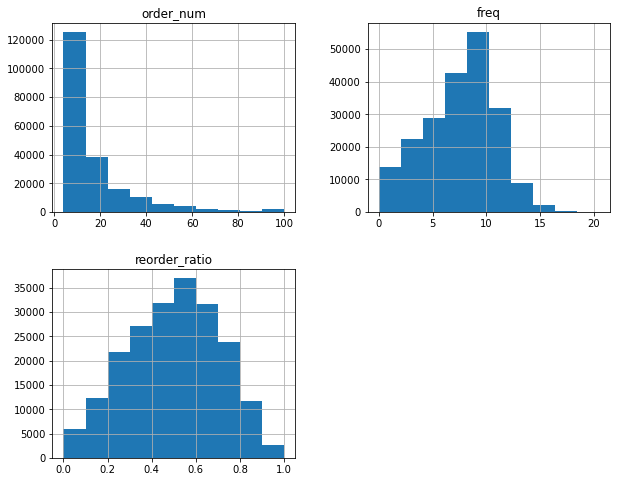

In [13]:
prefer.hist(figsize=(10,8))

<ipython-input-14-7eb144374a26>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prefer["order_num"] = np.log(prefer["order_num"])


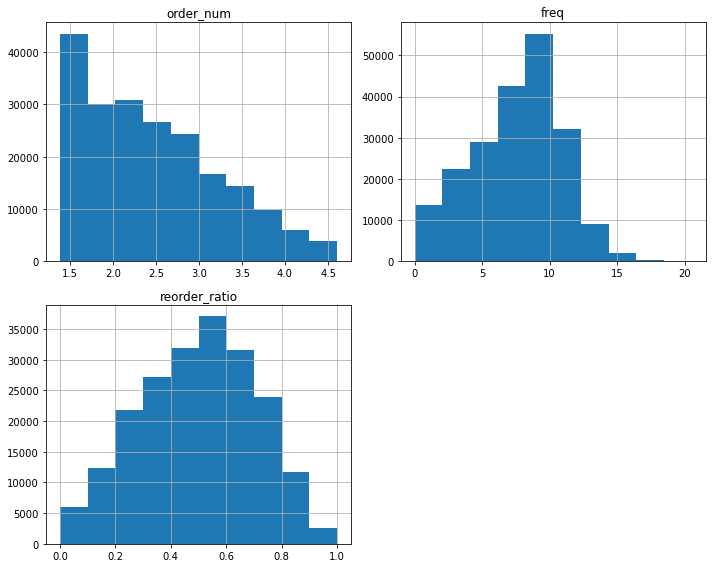

In [14]:
# 訂單總數分布太過右偏，重新定義並作圖

import numpy as np

prefer["order_num"] = np.log(prefer["order_num"])
prefer.hist(figsize=(10,8))
plt.tight_layout();

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feat_scaled = scaler.fit_transform(prefer)
feat_scaled = pd.DataFrame(feat_scaled)
feat_scaled.describe()

,0,1,2
count,2.061600e+05,2.061600e+05,2.061600e+05
mean,-2.559448e-17,3.723922e-16,5.312422e-16
std,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.333416e+00,-2.270486e+00,-2.372951e+00
25%,-8.272773e-01,-6.863826e-01,-7.320981e-01
50%,-1.896176e-01,1.407977e-01,3.085313e-02
75%,6.756326e-01,7.099861e-01,7.657163e-01
max,2.684681e+00,3.891614e+00,2.400439e+00


## Step 2. 決定K值



In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import seaborn as sns

# !pip3 install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


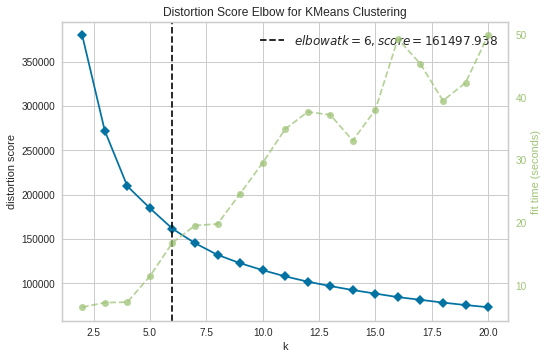

In [17]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 21))

visualizer.fit(feat_scaled)   
visualizer.show();

No. Clusters: 2, Silhouette Score: 0.34, Change from Previous Cluster: 0.0
No. Clusters: 3, Silhouette Score: 0.361, Change from Previous Cluster: 0.021
No. Clusters: 4, Silhouette Score: 0.326, Change from Previous Cluster: -0.035
No. Clusters: 5, Silhouette Score: 0.317, Change from Previous Cluster: -0.009
No. Clusters: 6, Silhouette Score: 0.282, Change from Previous Cluster: -0.035
No. Clusters: 7, Silhouette Score: 0.28, Change from Previous Cluster: -0.002
No. Clusters: 8, Silhouette Score: 0.277, Change from Previous Cluster: -0.003


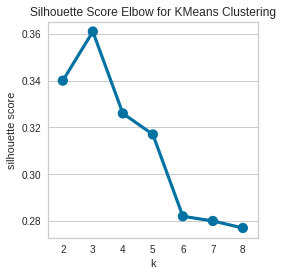

In [18]:
# Define a function to test KMeans at various k
# This approach uses silhouette score to evaluate KMeans
def optimal_kmeans(dataset, start=2, end=11):
    '''
    Calculate the optimal number of kmeans
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit
        start : int. Starting range of kmeans to test
        end : int. Ending range of kmeans to test
    OUTPUT:
        Values and line plot of Silhouette Score.
    '''
    
    # Create empty lists to store values for plotting graphs
    n_clu = []
    km_ss = []

    # Create a for loop to find optimal n_clusters
    for n_clusters in range(start, end):

        # Create cluster labels
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(dataset)

        # Calcualte model performance
        silhouette_avg = round(silhouette_score(dataset, labels, 
                                                random_state=1), 3)

        # Append score to lists
        km_ss.append(silhouette_avg)
        n_clu.append(n_clusters)

        print("No. Clusters: {}, Silhouette Score: {}, Change from Previous Cluster: {}".format(
            n_clusters, 
            silhouette_avg, 
            (km_ss[n_clusters - start] - km_ss[n_clusters - start - 1]).round(3)))

        # Plot graph at the end of loop
        if n_clusters == end - 1:
            plt.figure(figsize=(4,4))

            plt.title('Silhouette Score Elbow for KMeans Clustering')
            plt.xlabel('k')
            plt.ylabel('silhouette score')
            sns.pointplot(x=n_clu, y=km_ss)
            plt.savefig('silhouette_score.png', format='png', dpi=300,
                        pad_inches=2.0)
            plt.tight_layout()
            plt.show()
            
optimal_kmeans(feat_scaled, 2, 9)

(               0         1         2  Cluster
 0      -0.070643 -0.332055  1.372324        1
 1       0.316521  0.815331 -0.019871        1
 2       0.137890 -0.727548  0.992901        1
 3      -0.827277 -0.364022 -2.031994        0
 4      -1.054868 -0.633744  0.081935        2
 ...          ...       ...       ...      ...
 206155 -1.333416  1.199399 -0.407437        0
 206156  2.203262 -1.293349 -0.079685        3
 206157  0.472761  1.078841  0.769331        1
 206158  1.819431 -1.070099  1.065325        3
 206159  0.230398  1.088354  0.129229        1
 
 [206160 rows x 4 columns],
 array([1, 1, 1, ..., 1, 3, 1], dtype=int32))

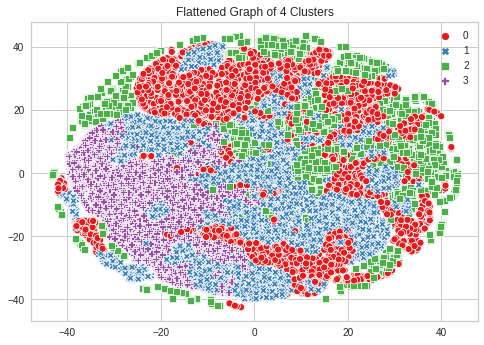

In [19]:
# Define a function to calculate and plot specified # of clusters
def cluster_draw(df, clusters_number):
    '''
    Implement k-means clustering on dataset
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit.
        clusters_number : int. Number of clusters to form.
        end : int. Ending range of kmeans to test.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''   
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(df)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = df.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], 
                    hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new, cluster_labels

# 分群t-SNE繪圖
cluster_draw(feat_scaled, 4)

(               0         1         2  Cluster
 0      -0.070643 -0.332055  1.372324        2
 1       0.316521  0.815331 -0.019871        1
 2       0.137890 -0.727548  0.992901        2
 3      -0.827277 -0.364022 -2.031994        0
 4      -1.054868 -0.633744  0.081935        0
 ...          ...       ...       ...      ...
 206155 -1.333416  1.199399 -0.407437        1
 206156  2.203262 -1.293349 -0.079685        2
 206157  0.472761  1.078841  0.769331        2
 206158  1.819431 -1.070099  1.065325        2
 206159  0.230398  1.088354  0.129229        1
 
 [206160 rows x 4 columns],
 array([2, 1, 2, ..., 2, 2, 1], dtype=int32))

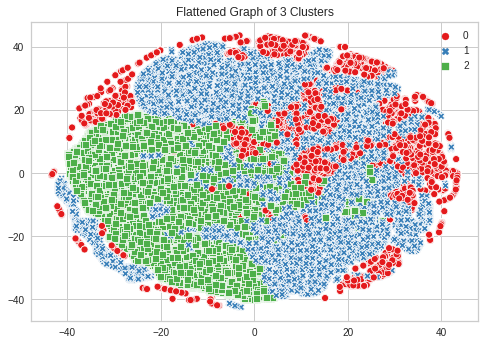

In [20]:
# 分群t-SNE繪圖

cluster_draw(feat_scaled, 3)